Based on:
 * My [previous notebook DDGAN 101](google.com)
 * This [github repo with Flow Matching implementation ](github.com/gle-bellier/flow-matching/)

## Imports

In [ ]:
!pip install lmdb
!pip install zuko
!pip install torchdiffeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 4.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.distributions import Normal
from torch.utils.data import TensorDataset, Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from zuko.utils import odeint

import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

import os
from functools import partial
from typing import *

from IPython.display import clear_output
from tqdm import tqdm

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

## Data generation

In [ ]:
from sklearn.utils import check_random_state

def my_swiss_roll(n_samples=100, *, noise=0.0, phi_min=1.5*np.pi, phi_max=4.5*np.pi, r_min=5.0, r_max=15.0, random_state=None):
    generator = check_random_state(random_state)
    assert phi_max > phi_min
    assert r_max > r_min

    t = generator.uniform(size=n_samples)
    phi = t * (phi_max - phi_min) + phi_min
    r = t * (r_max - r_min) + r_min

    res = generator.randn(n_samples, 2,) * noise
    res[:, 0] += r * np.cos(phi)
    res[:, 1] += r * np.sin(phi)

    return res

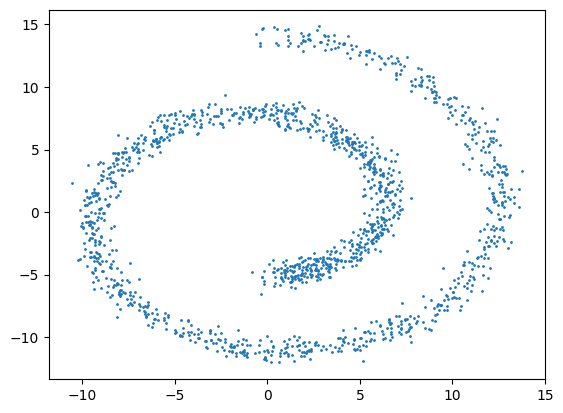

In [ ]:
n_samples = 1500
noise = 0.5
X = my_swiss_roll(
    n_samples, noise=noise,
    phi_min=1.5*np.pi, phi_max=4.5*np.pi, r_min=1.5*np.pi, r_max=4.5*np.pi,
)

plt.scatter(X[:, 0], X[:, 1], s=1)

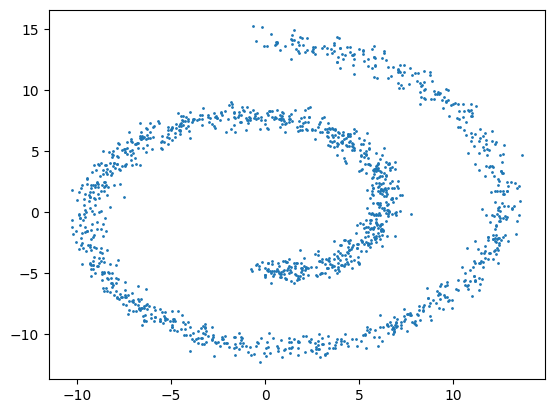

In [ ]:
from sklearn.datasets import make_swiss_roll

n_samples = 1500
noise = 0.5
X, _ = make_swiss_roll(n_samples, noise=noise)

plt.scatter(X[:, 0], X[:, 2], s=1)

[]

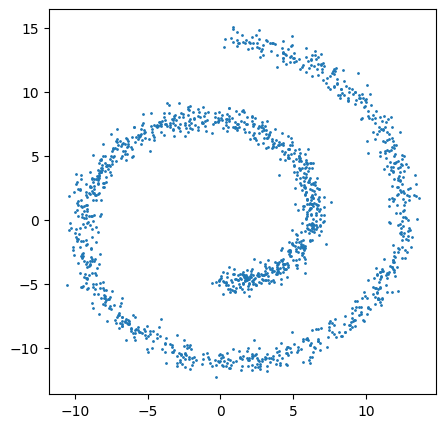

In [ ]:
k = 1

args = {
    'num_timesteps': k * k - 1,
    'beta_min': 0.1,
    'beta_max': 20.,
}
args = dotdict(args)

n_samples = 1500
noise = 0.5
X = my_swiss_roll(
    n_samples, noise=noise,
    phi_min=1.5*np.pi, phi_max=4.5*np.pi, r_min=1.5*np.pi, r_max=4.5*np.pi,
)
X = torch.from_numpy(X)
plt.figure(figsize=(5, 5))
plt.subplot(k, k, 1)
plt.scatter(X[:, 0], X[:, 1], s=1)
# coeff = Diffusion_Coefficients(args, 'cpu')

# #sample t
# for i in range(args.num_timesteps):
#     t = torch.zeros(X.size(0), dtype=torch.int64) + i

#     x_t, x_tp1 = q_sample_pairs(coeff, X, t)

#     plt.subplot(k, k, i + 2)
#     plt.scatter(x_tp1[:, 0], x_tp1[:, 1], s=1)

plt.plot()

In [ ]:
from sklearn.utils import check_random_state

def my_k2_gaussian(n_samples=100, *, noise=1.0, k=3, random_state=None):
    generator = check_random_state(random_state)

    return generator.randint(0, k, size=(n_samples, 2)) + generator.randn(n_samples, 2,) * noise

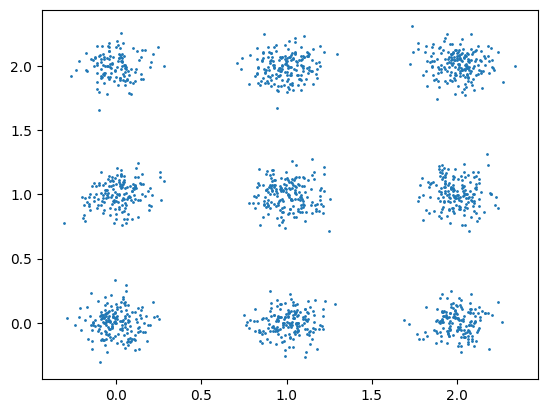

In [ ]:
n_samples = 1500
noise = 0.1
X = my_k2_gaussian(
    n_samples, noise=noise, k = 3,
)

plt.scatter(X[:, 0], X[:, 1], s=1)

[]

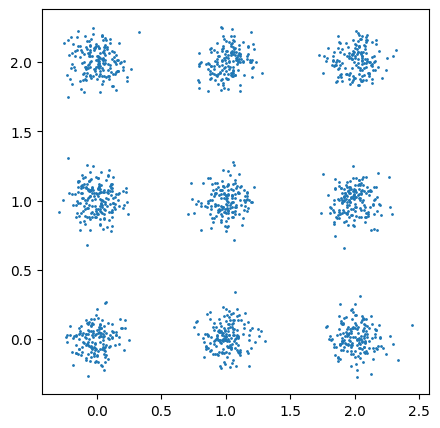

In [ ]:
k = 1

args = {
    'num_timesteps': k * k - 1,
    'beta_min': 0.1,
    'beta_max': 20.,
}
args = dotdict(args)

n_samples = 1500
noise = 0.1
X = my_k2_gaussian(
    n_samples, noise=noise, k = 3,
)

X = torch.from_numpy(X)
plt.figure(figsize=(5, 5))
plt.subplot(k, k, 1)
plt.scatter(X[:, 0], X[:, 1], s=1)
# coeff = Diffusion_Coefficients(args, 'cpu')

# #sample t
# for i in range(args.num_timesteps):
#     t = torch.zeros(X.size(0), dtype=torch.int64) + i

#     x_t, x_tp1 = q_sample_pairs(coeff, X, t)

#     plt.subplot(k, k, i + 2)
#     plt.scatter(x_tp1[:, 0], x_tp1[:, 1], s=1)

plt.plot()

## Flow matching

In [ ]:
class OTFlowMatching:

  def __init__(self, sig_min: float = 0.001) -> None:
    super().__init__()
    self.sig_min = sig_min
    self.eps = 1e-5

  def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """ Conditional Flow
    """
    return (1 - (1 - self.sig_min) * t) * x + t * x_1

  def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """
    # t ~ Unif([0, 1])
    t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
    t = t[:, None].expand(x_1.shape)
    # x ~ p_t(x_0)
    x_0 = torch.randn_like(x_1)
    v_psi = v_t(t[:,0], self.psi_t(x_0, x_1, t))
    d_psi = x_1 - (1 - self.sig_min) * x_0
    return torch.mean((v_psi - d_psi) ** 2)

In [ ]:
class VPDiffusionFlowMatching:

  def __init__(self) -> None:
    super().__init__()
    self.beta_min = 0.1
    self.beta_max = 20.0
    self.eps = 1e-5

  def T(self, s: torch.Tensor) -> torch.Tensor:

    return self.beta_min * s + 0.5 * (s ** 2) * (self.beta_max - self.beta_min)

  def beta(self, t: torch.Tensor) -> torch.Tensor:

    return self.beta_min + t*(self.beta_max - self.beta_min)

  def alpha(self, t: torch.Tensor) -> torch.Tensor:

    return torch.exp(-0.5 * self.T(t))

  def mu_t(self, t: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:

    return self.alpha(1. - t) * x_1

  def sigma_t(self, t: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:

    return torch.sqrt(1. - self.alpha(1. - t) ** 2)

  def u_t(self, t: torch.Tensor, x: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:

    num = torch.exp(-self.T(1. - t)) * x - torch.exp(-0.5 * self.T(1.-t))* x_1
    denum = 1. - torch.exp(- self.T(1. - t))
    return - 0.5 * self.beta(1. - t) * (num/denum)


  def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """
    # t ~ Unif([0, 1])
    t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
    t = t[:, None].expand(x_1.shape)
    # x ~ p_t(x|x_1)
    x = self.mu_t(t, x_1) + self.sigma_t(t, x_1) * torch.randn_like(x_1)

    return torch.mean((v_t(t[:,0], x) - self.u_t(t, x, x_1)) ** 2)

In [ ]:
class VEDiffusionFlowMatching:

  def __init__(self) -> None:
    super().__init__()
    self.sigma_min = 0.01
    self.sigma_max = 2.
    self.eps = 1e-5


  def sigma_t(self, t: torch.Tensor) -> torch.Tensor:

    return self.sigma_min * (self.sigma_max / self.sigma_min) ** t

  def dsigma_dt(self, t: torch.Tensor) -> torch.Tensor:

    return self.sigma_t(t) * torch.log(torch.tensor(self.sigma_max/self.sigma_min))

  def u_t(self, t: torch.Tensor, x: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:

    return -(self.dsigma_dt(1. - t) / self.sigma_t(1. - t)) * (x - x_1)

  def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """
    # t ~ Unif([0, 1])
    t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
    t = t[:, None].expand(x_1.shape)
    # x ~ p_t(x|x_1)
    x = x_1 + self.sigma_t(1. - t) * torch.randn_like(x_1)

    return torch.mean((v_t(t[:,0], x) - self.u_t(t, x, x_1)) ** 2)

In [ ]:
class CondVF(nn.Module):
  def __init__(self, net: nn.Module, n_steps: int = 100) -> None:
    super().__init__()
    self.net = net

  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    return self.net(t, x)

  def wrapper(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
      t = t * torch.ones(len(x), device=x.device)
      return self(t, x)

  def decode_t0_t1(self, x_0, t0, t1):
    return odeint(self.wrapper, x_0, t0, t1, self.parameters())


  def encode(self, x_1: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_1, 1., 0., self.parameters())

  def decode(self, x_0: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_0, 0., 1., self.parameters())

In [ ]:
class Net(nn.Module):
  def __init__(self, in_dim: int, out_dim: int, h_dims: List[int], n_frequencies:int) -> None:
    super().__init__()

    ins = [in_dim + 2 * n_frequencies] + h_dims
    outs = h_dims + [out_dim]
    self.n_frequencies = n_frequencies

    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)
    ])
    self.top = nn.Sequential(nn.Linear(out_dim, out_dim))

  def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
    freq = 2 * torch.arange(self.n_frequencies, device=t.device) * torch.pi
    t = freq * t[..., None]
    return torch.cat((t.cos(), t.sin()), dim=-1)

  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    t = self.time_encoder(t)
    x = torch.cat((x, t), dim=-1)

    for l in self.layers:
      x = l(x)
    return self.top(x)

In [ ]:
def get_model(name: str):
    if name == "vp":
      return VPDiffusionFlowMatching()
    elif name == "ve":
      return VEDiffusionFlowMatching()
    if name == "ot":
      return OTFlowMatching()

## Training functions

In [ ]:
class MySampler:
    def __init__(self, batch_size, sample_func=my_swiss_roll, precalc=None):
        self.precalc = precalc
        self.batch_size = batch_size
        self.sample_func = sample_func

        if self.precalc is not None:
            self.regenerate()

    def regenerate(self):
        self.generated = self.sample_func(self.precalc * self.batch_size,)
        self.idx = 0

    def sample(self):
        if self.precalc is None:
            return self.sample_func(self.batch_size,)
        if self.idx == self.precalc:
            self.regenerate()
        ret = self.generated[self.idx * self.batch_size: (self.idx + 1) * self.batch_size]
        self.idx += 1
        return ret

In [ ]:
def train_model(args):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    batch_size = args.batch_size

    model = get_model(args.model_type)

    v_t = CondVF(Net(
        in_dim = args.x_dim,
        out_dim = args.out_dim,
        h_dims=args.h_layers,
        n_frequencies=args.n_freqs,
    )).to(device)


    optimizer = torch.optim.Adam(v_t.parameters(), lr=args.lr, betas = (args.beta1, args.beta2))

    global_iteration, init_iteration = 0, 0
    if args.resume:
        checkpoint_file = os.path.join(args.exp_path, 'content.pth')
        checkpoint = torch.load(checkpoint_file, map_location=device)
        init_iteration = checkpoint['iteration']
        global_iteration = init_iteration

        # load model
        v_t.load_state_dict(checkpoint['v_t_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])

        print("=> loaded checkpoint (iteration {})"
                  .format(init_iteration))

    sampler = MySampler(
        batch_size=args.batch_size,
        sample_func=args.sample_func,
        precalc=args.precalc,
    )
    history = {
        'loss': [],
    }
    history = dotdict(history)

    for iteration in tqdm(range(init_iteration, args.num_iterations + 1)):
        x_1 = sampler.sample()
        x_1 = torch.from_numpy(x_1).to(torch.float32).to(device, non_blocking=True)

        # compute loss
        loss = model.loss(v_t, x_1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history.loss.append(loss.detach().cpu().numpy())

        if args.visualize and (iteration + 1) % args.visualize_every == 0:
            n_samples = 10_000
            with torch.no_grad():
                x_0 = torch.randn(args.batch_size, 2, device=device)
                x_fake = v_t.decode(x_0).detach().cpu().numpy()

            x_real = sampler.sample()

            clear_output(wait=True)
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 3, 1)
            plt.plot(history.loss)
            plt.title('loss')

            plt.subplot(1, 3, 2)
            plt.scatter(x_real[:, 0], x_real[:, 1], s=1, label='real')
            plt.title('Real data')
            plt.legend()
            plt.gca().set_aspect('equal', adjustable='box')
            xlim = plt.gca().get_xlim()
            ylim = plt.gca().get_ylim()

            plt.subplot(1, 3, 3)
            plt.scatter(x_fake[:, 0], x_fake[:, 1], s=1, label='fake')
            plt.title('Generated data')
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_xlim(xlim)
            plt.gca().set_ylim(ylim)
            plt.legend()

            plt.show()

        if args.print and (iteration + 1) % args.print_every == 0:
            print('iteration: {} | loss: {}'.format(iteration, loss.item()))

        if args.exp_path is not None and args.save_content and (iteration + 1) % args.save_content_every == 0:
            print('Saving content.')
            content = {
                'iteration': iteration,
                # 'args': args,
                'v_t_dict': v_t.state_dict(),
                'optimizer': optimizer.state_dict(),
            }

            torch.save(content, os.path.join(args.exp_path, 'content.pth'))

## Swiss roll experiment

#### Hyperparameters


In [ ]:
args = {
    'model_type': "ot",
    'x_dim': 2,
    't_dim': 2,
    'out_dim': 2,
    'n_freqs': 10,
    'h_layers': [512] * 4,
    'layers_D': [256, 256, 256],
    'num_iterations': 50000,
    'batch_size': 512,
    'lr': 1e-3,
    'beta1': 0.5,
    'beta2': 0.9,
    'sampler_precalc': 1000,
    'sampler_gen_params':{},
    'sample_func': partial(
        my_swiss_roll,
        noise=0.5,
        phi_min=1.5 * np.pi,
        phi_max=6.5 * np.pi,
        r_min=2,
        r_max=20,
    ),
    'exp_path': "./swiss_roll/",
    'save_ckpt':True,
    'save_ckpt_every': 5000,
    'save_content':True,
    'save_content_every': 5000,
    'visualize':True,
    'visualize_every': 1000,
    'print': True,
    'print_every': 100,
    'resume': False,
}
args = dotdict(args)

In [ ]:
!rm -rf $args.exp_path
!mkdir $args.exp_path

#### Training

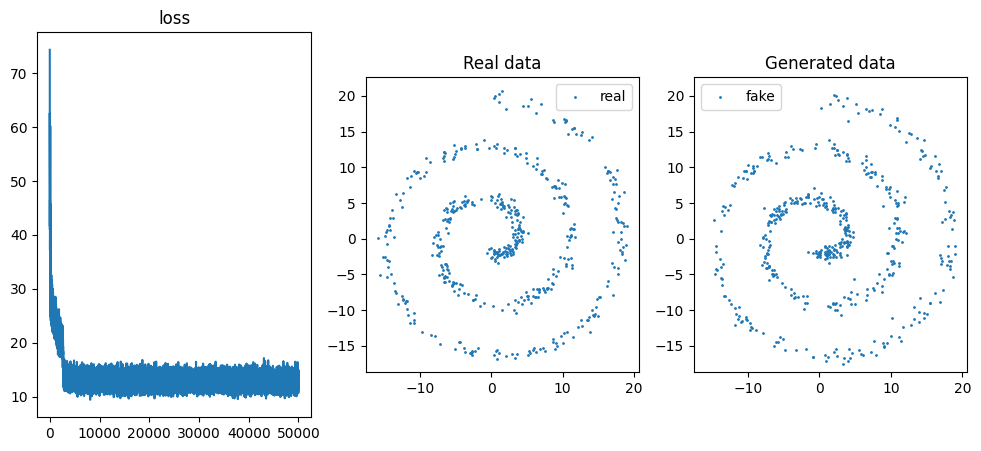

100%|██████████| 50001/50001 [04:01<00:00, 207.34it/s]

iteration: 49999 | loss: 10.7813138961792
Saving content.


In [ ]:
train_model(args)

#### Visualization

In [ ]:
def visualize_generation(args, checkpoint_name=None, batch_size=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if batch_size is None:
        batch_size = args.batch_size

    if checkpoint_name is None:
        checkpoint_name = "content.pth"

    model = get_model(args.model_type)

    v_t = CondVF(Net(
        in_dim = args.x_dim,
        out_dim = args.out_dim,
        h_dims=args.h_layers,
        n_frequencies=args.n_freqs,
    )).to(device)

    checkpoint_file = os.path.join(args.exp_path, checkpoint_name)
    checkpoint = torch.load(checkpoint_file, map_location=device)

    # load model
    v_t.load_state_dict(checkpoint['v_t_dict'])

    print("=> loaded checkpoint (iteration {})"
                .format(checkpoint['iteration']))

    v_t.eval()
    with torch.no_grad():
        x_0 = torch.randn(batch_size, 2, device=device)
        x_fake = v_t.decode(x_0).detach().cpu().numpy()
    x_real = args.sample_func(batch_size)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(x_real[:, 0], x_real[:, 1], s=1, label='real')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()

    plt.subplot(1, 2, 2)
    plt.scatter(x_fake[:, 0], x_fake[:, 1], s=1, label='fake')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_xlim(xlim)
    plt.gca().set_ylim(ylim)
    plt.legend()
    plt.suptitle('Visualization')

    plt.show()

=> loaded checkpoint (iteration 49999)


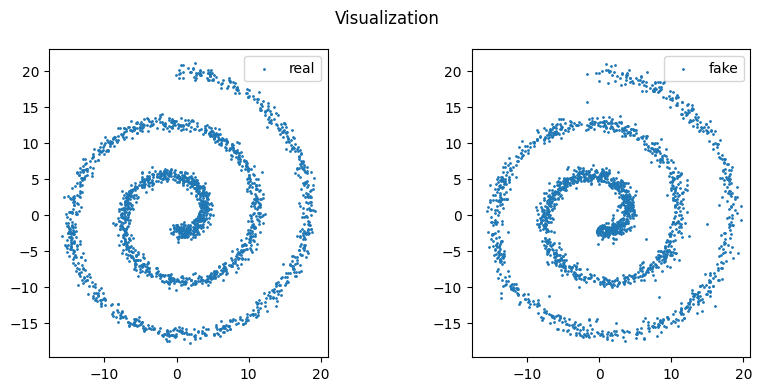

In [ ]:
visualize_generation(args, batch_size=2048)

In [ ]:
from math import sqrt, ceil

def visualize_trajectories(args, checkpoint_name=None, batch_size=None, n_steps=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if batch_size is None:
        batch_size = args.batch_size

    if checkpoint_name is None:
        checkpoint_name = "content.pth"

    model = get_model(args.model_type)

    v_t = CondVF(Net(
        in_dim = args.x_dim,
        out_dim = args.out_dim,
        h_dims=args.h_layers,
        n_frequencies=args.n_freqs,
    )).to(device)

    checkpoint_file = os.path.join(args.exp_path, checkpoint_name)
    checkpoint = torch.load(checkpoint_file, map_location=device)

    # load model
    v_t.load_state_dict(checkpoint['v_t_dict'])

    print("=> loaded checkpoint (iteration {})"
                .format(checkpoint['iteration']))

    v_t.eval()
    with torch.no_grad():
        x_0 = torch.randn(batch_size, 2, device=device)
        x_fake = v_t.decode(x_0).detach().cpu().numpy()
    x_real = args.sample_func(batch_size)

    t_steps = torch.linspace(0, 1, n_steps, device=device)
    with torch.no_grad():
        x_t = [torch.randn(batch_size, 2, device=device)]
        for t in range(len(t_steps) - 1):
            x_t += [v_t.decode_t0_t1(x_t[-1], t_steps[t], t_steps[t+1])]

    k = ceil(sqrt(n_steps))

    for t in range(n_steps):
        x_t[t] = x_t[t].detach().cpu().numpy()

    plt.figure(figsize=(16, 14))
    for i, point in enumerate(x_t):
        plt.subplot(k, k, i + 1)
        plt.scatter(point[:, 0], point[:, 1], s=1, label=f'step {i+1}')
        plt.legend()
        plt.gca().set_aspect('equal', adjustable='box')

    plt.suptitle('Trajectories visualization')

    plt.show()

=> loaded checkpoint (iteration 49999)


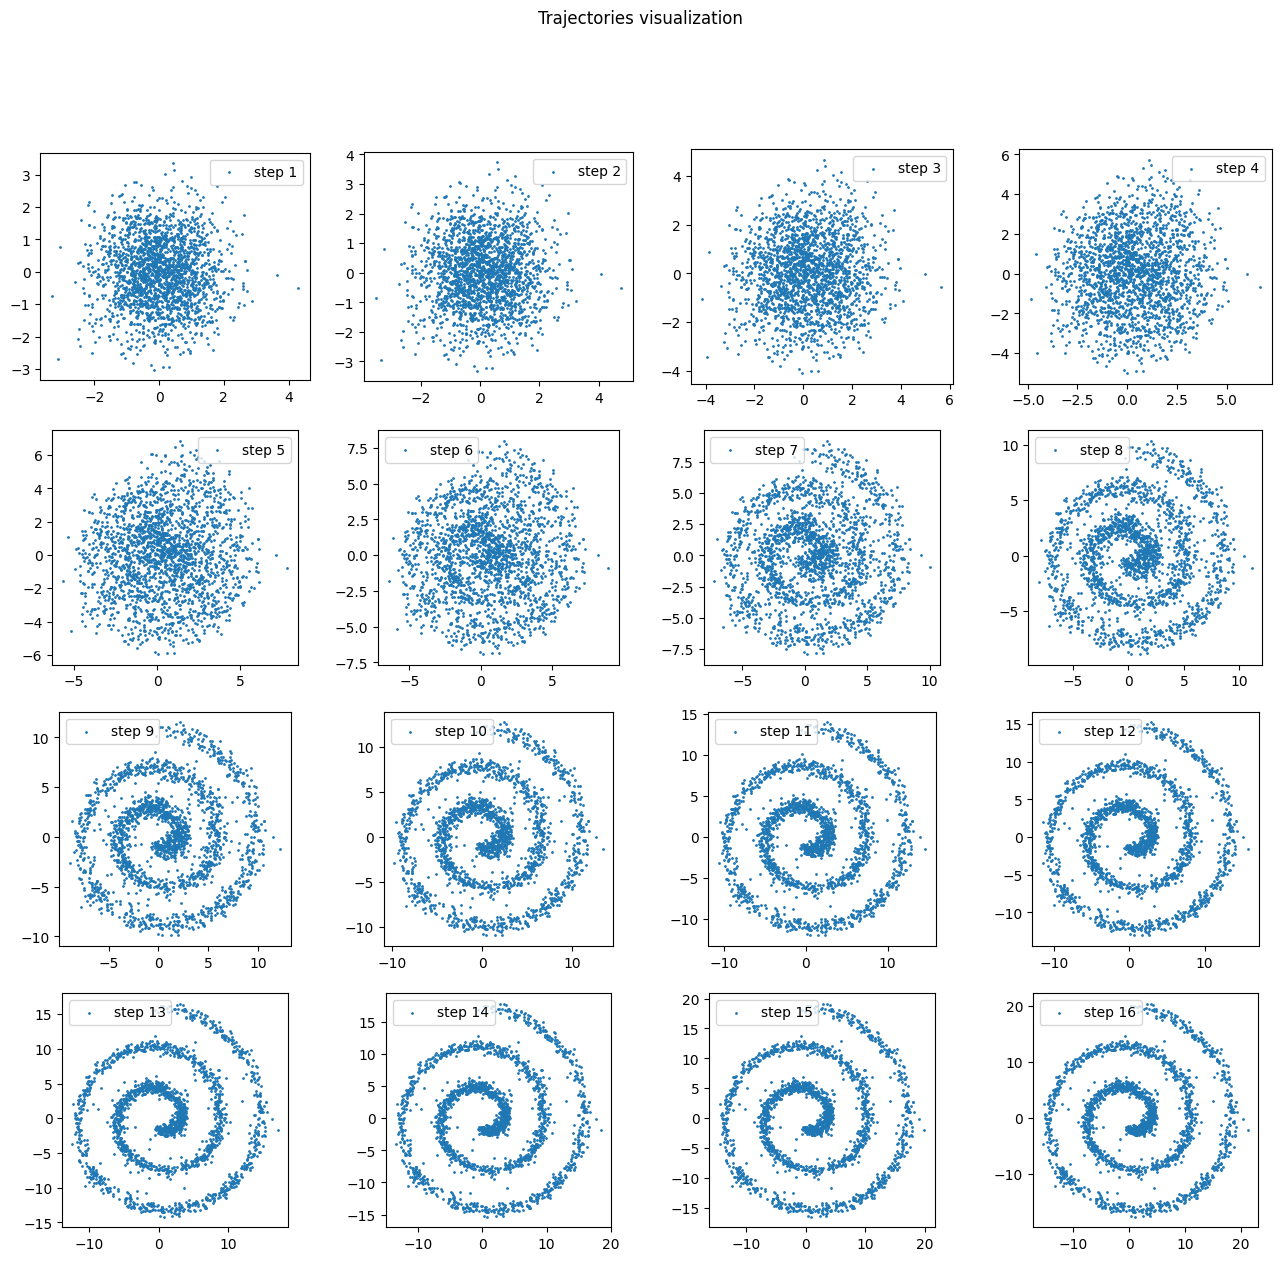

In [ ]:
visualize_trajectories(args, batch_size=2048)

## N-Gaussian experiment

#### Hyperparameters


In [ ]:
args = {
    'model_type': "ot",
    'x_dim': 2,
    't_dim': 2,
    'out_dim': 2,
    'n_freqs': 10,
    'h_layers': [512] * 4,
    'layers_D': [256, 256, 256],
    'num_iterations': 50000,
    'batch_size': 512,
    'lr': 1e-3,
    'beta1': 0.5,
    'beta2': 0.9,
    'sampler_precalc': 1000,
    'sampler_gen_params':{},
    'sample_func': partial(
        my_k2_gaussian,
        noise=0.1,
        k=3,
    ),
    'exp_path': "./n_gaussian/",
    'save_ckpt':True,
    'save_ckpt_every': 5000,
    'save_content':True,
    'save_content_every': 5000,
    'visualize':True,
    'visualize_every': 1000,
    'print': True,
    'print_every': 100,
    'resume': False,
}
args = dotdict(args)

In [ ]:
!rm -rf $args.exp_path
!mkdir $args.exp_path

#### Training

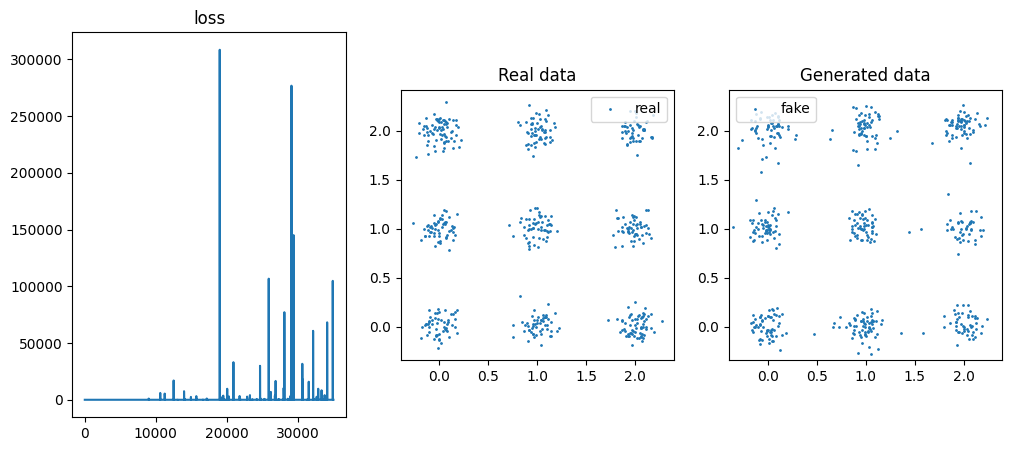

 70%|███████   | 35029/50001 [02:39<10:39, 23.42it/s] 

iteration: 34999 | loss: 1.009227991104126
Saving content.


 70%|███████   | 35172/50001 [02:39<03:00, 82.16it/s]

iteration: 35099 | loss: 1.1486966609954834


 70%|███████   | 35244/50001 [02:40<01:49, 135.16it/s]

iteration: 35199 | loss: 1.1400269269943237


 71%|███████   | 35354/50001 [02:40<01:03, 231.62it/s]

iteration: 35299 | loss: 1.25457763671875


 71%|███████   | 35462/50001 [02:40<00:49, 296.10it/s]

iteration: 35399 | loss: 1.1369284391403198


 71%|███████   | 35571/50001 [02:41<00:43, 331.67it/s]

iteration: 35499 | loss: 1.2115100622177124


 71%|███████▏  | 35644/50001 [02:41<00:41, 341.86it/s]

iteration: 35599 | loss: 1.11500883102417


 72%|███████▏  | 35753/50001 [02:41<00:40, 350.51it/s]

iteration: 35699 | loss: 1.215425729751587


 72%|███████▏  | 35862/50001 [02:41<00:40, 352.31it/s]

iteration: 35799 | loss: 1.154756784439087


 72%|███████▏  | 35935/50001 [02:42<00:41, 335.80it/s]

iteration: 35899 | loss: 1.2169773578643799


 72%|███████▏  | 35999/50001 [04:42<01:49, 127.64it/s]


KeyboardInterrupt: 

In [78]:
train_model(args)

#### Visualization

=> loaded checkpoint (iteration 34999)


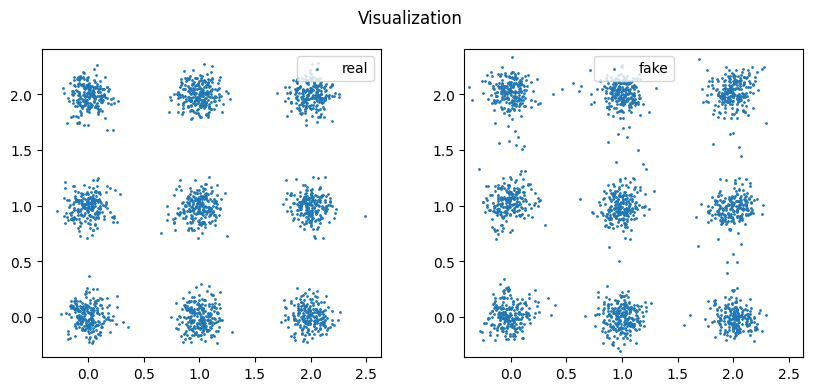

In [79]:
visualize_generation(args, batch_size=2048)

=> loaded checkpoint (iteration 34999)


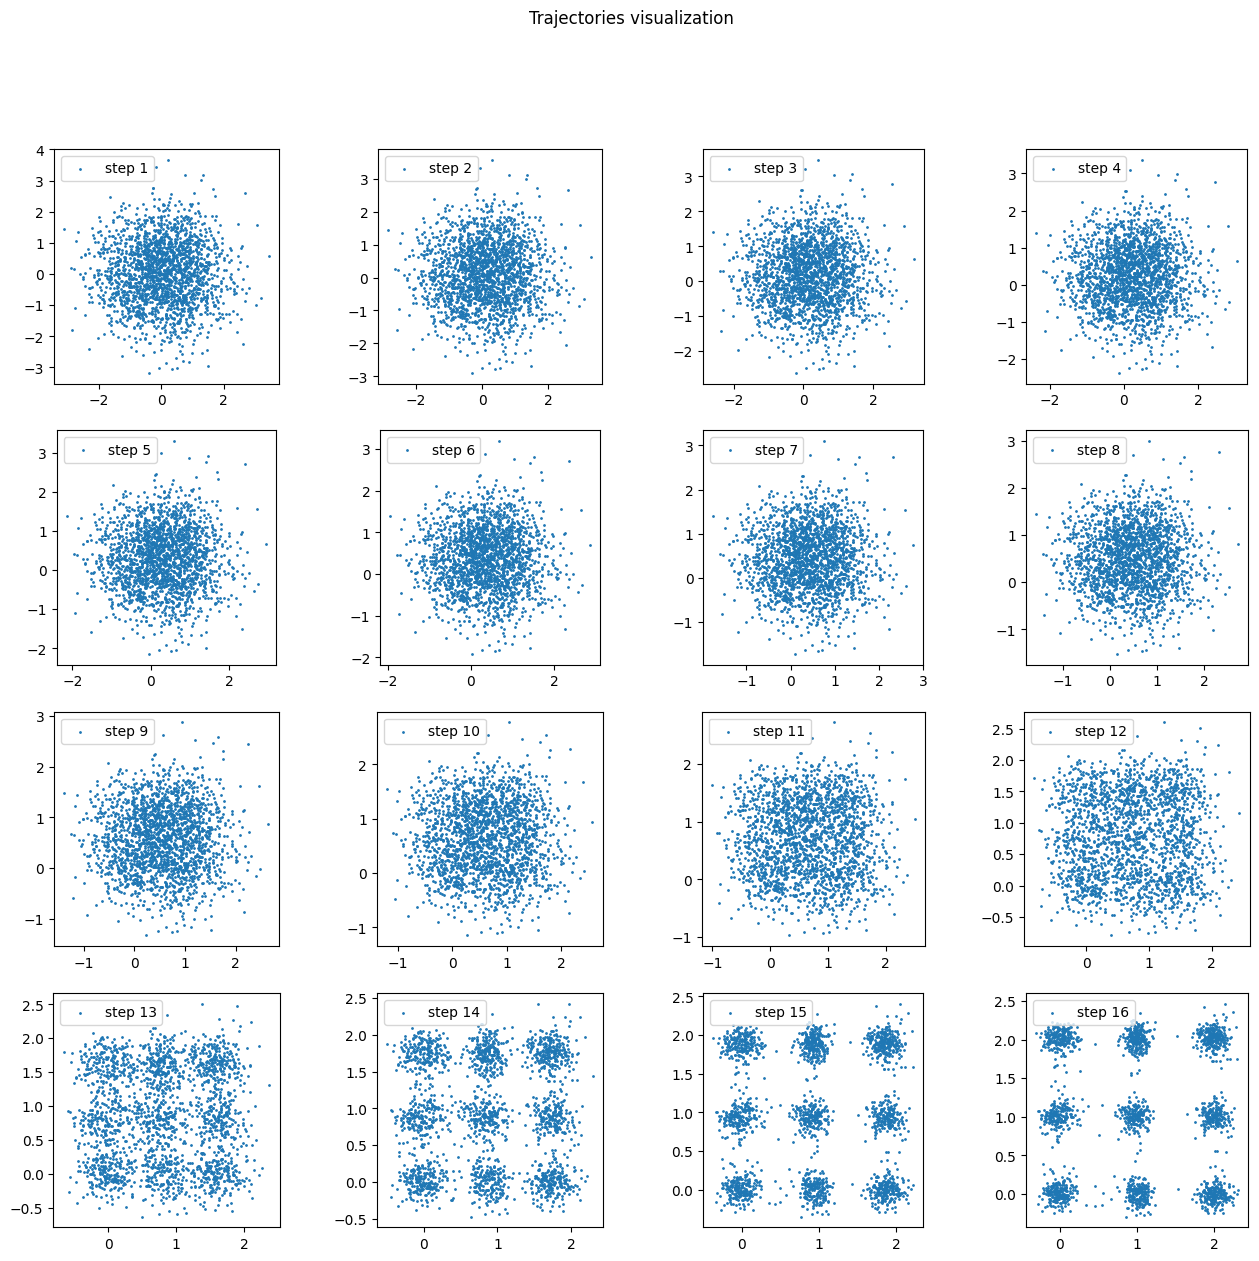

In [80]:
visualize_trajectories(args, batch_size=2048)